In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
gravity = 9.8

<h3>Problem</h3>

<p>Our goal is to find the shape of a hanging chain. To do this, we assume a chain is made of many masses connected by strings. Typically, one assumes that the chain is made of identical masses and strings and that the only external force is gravity. This yeilds the catenary. The approach we take below is more general. It adds symmetry to the calculations and code and allows us to consider more interesting situations.</p>

<h3>Notation</h3>

<p>A chain is made by connecting $N$ masses with $N + 1$ strings. Let $i$ range from $1$ to $N$ and $j$ range from $0$ to $N$. Mass $i$ has position $(x_i, y_i)$ and an external force $(f_i, g_i)$ acting on it. String $j$ has end positions $(x_j, y_j)$ and $(x_{j+1}, y_{j+1})$, length $\ell_j$, and tension $T_j$. The chain has fixed end positions $(x_0, y_0)$ and $(x_{N+1}, y_{N+1})$.</p>

<p>To sumarize, this problem has given variables $(f_i, g_i)$, $\ell_j$, $(x_0, y_0)$, and $(x_{N+1}, y_{N+1})$. Our goal is to find the unknow variables $(x_i, y_i)$ and $T_j$.</p>

<h3>Calculations</h3>

<p>We treat this as an optimization problem where we are trying to minimumize the potential energy of the chain subject to string length constraints. We use the Lagrange multiplier method were the multipliers are labeled $T_j$. Our goal is to minimumize $U(x_i, y_i, T_j)$.</p>

$$ U = - \sum_{i=1}^N(f_i x_i + g_i y_i) 
  + \sum_{j=0}^N \frac{T_j}{2 \ell_j} \left[(x_{j+1} - x_j)^2 + (y_{j+1} - y_j)^2 - \ell_j^2 \right] $$

<p>To minimumize $U$, we find its gradient. We divide this gradient into parts and label the parts. (See appendix A for calculation details.)</p>

\begin{align*}
F_i &= - \frac{\partial U}{\partial x_i}
     = f_i + \frac{T_i}{\ell_j} (x_{i+1} - x_i) - \frac{T_{i-1}}{\ell_{j-1}} (x_i - x_{i-1}) \\   
G_i &= - \frac{\partial U}{\partial y_i}
     = g_i + \frac{T_i}{\ell_j} (y_{i+1} - y_i) - \frac{T_{i-1}}{\ell_{j-1}} (y_i - y_{i-1}) \\
H_j &= - \frac{\partial U}{\partial T_j}
     = \frac{1}{2 \ell_i} \left[ \ell_j^2 - (x_{j+1} - x_j)^2 - (y_{j+1} - y_j)^2 \right]
\end{align*}

<p>Let $\theta_j$ be the angle string $j$ makes with horizontal. The equations for $F_i$ and $G_i$ can be rewritten.</p>

\begin{align*}
F_i &= f_i + T_i \cos(\theta_i) - T_{i-1} \cos(\theta_{i-1}) \\   
G_i &= g_i + T_i \sin(\theta_i) - T_{i-1} \sin(\theta_{i-1})
\end{align*}

<p>We see that $(F_i, G_i)$ can be interpreted as the net force on mass $i$ and that the Lagrange multiplier $T_j$ can be interpreted as the tension in string $j$.</p>

<p>The chain is at rest when the gradient of $U$ is zero or, alternatively, when all of the net forces are equal to zero. We have the same number of equations as unknowns. The equations, however, are nonlinear and solving for the unknowns is not easy.</p>

<h3>Optimization</h3>

<p>To find the shape of the chain and tension, we will use an optimization algorith to minimumize $U$ with respect to the unknown variables $(x_i, y_i$) and $T_j$. The algorithm requires an initial guess for the unknown variables.</p>

<p>The algorith is helped when given the gradient of $U$ or, alternatively, the negative forces. If $U$ is not at a minimum, force $(F_i, G_i)$ indicates how mass $i$ will move and, hence, how $(x_i, y_i)$ should change. Similarly, "force" $H_j$ indicates how $T_j$ should change. If string $j$ is too long, for example, $H_j$ is negative and $T_i$ should decreased. This is counter intuative though consistent with the goal of decreasing $U$.</p>

In [47]:
def get_funcs_UFGH(f, g, l, x0, y0, xN1, yN1):
    
    def func_U(x, y, T):
        X = np.concatenate([[x0], x, [xN1]])
        Y = np.concatenate([[y0], y, [yN1]])
        S1 = sum(f*x + g*y)
        S2 = sum(T/2/l*((X[1:] - X[:-1])**2 + (Y[1:] - Y[:-1])**2 - l**2))
        return -S1 + S2

    def func_F(x, y, T):
        X = np.concatenate([[x0], x, [xN1]])
        F1 = T[1:] /l[1:] *(X[2:]   - X[1:-1])
        F0 = T[:-1]/l[:-1]*(X[1:-1] - X[:-2] )
        return f + F1 - F0

    def func_G(x, y, T):
        Y = np.concatenate([[y0], y, [yN1]])
        G1 = T[1:] /l[1:] *(Y[2:]   - Y[1:-1])
        G0 = T[:-1]/l[:-1]*(Y[1:-1] - Y[:-2] )
        return g + G1 - G0

    def func_H(x, y, T):
        X = np.concatenate([[x0], x, [xN1]])
        Y = np.concatenate([[y0], y, [yN1]])
        return 1/2/l*(l**2 - (X[1:] - X[:-1])**2 - (Y[1:] - Y[:-1])**2)

    return [func_U, func_F, func_G, func_H]

In [112]:
def minimumize_U_FGH_xyT(func_U, func_F, func_G, func_H, x_init, y_init, T_init, N):

    # define a potential energy that is a function of a single vector
    def func_U_xyT(xyT):
        [x, y, T] = np.split(xyT, [N, 2*N])
        U = func_U(x, y, T)
        return U
    
    # define a gradient that is a function of a single vector
    # and returns a single vector
    def func_U_der_xyT(xyT):
        [x, y, T] = np.split(xyT, [N, 2*N])
        F = func_F(x, y, T)
        G = func_G(x, y, T)
        H = func_H(x, y, T)
        U_der_xyT = np.concatenate([-F, -G, -H])        
        return U_der_xyT

    # define initial values as a single vector
    xyT_init = np.concatenate([x_init, y_init, T_init])

    # this is where the work is done
    res = minimize(func_U_xyT, xyT_init, method='BFGS', jac=func_U_der_xyT, options={'disp': True})

    # return three vectors
    xyT = res.x
    [x, y, T] = np.split(xyT, [N, 2*N])
    
    return [x, y, T]

<h3>Gradient check</h3>

<p>Before continuing, we check that results from our force functions are consistent with discrete estimates. Angrew Ng says that difficulties here are the number one source of error in machine learnign. We choose $\Delta x \ll x_{i+1} - x_i $, $\Delta y \ll y_{i+1} - y_i $, and $\Delta T \ll T_{i+1} - T_i $ for any $i$.</p>

$$ (F_{\mathrm{approx}})_i = - \frac{U(x_i + \Delta x) - U(x_i)}{\Delta x}, \quad
   (G_{\mathrm{approx}})_i = - \frac{U(y_i + \Delta y) - U(y_i)}{\Delta y}, \quad
   (H_{\mathrm{approx}})_i = - \frac{U(T_i + \Delta T) - U(T_i)}{\Delta T} $$
   
<p>A simple calculation shows that $(H_{\mathrm{approx}})_i$ is exactly equal to $H_i$.</p>

In [113]:
def func_F_approx(x, y, T, func_U, Dx):
    xx = np.array([x for i in x])
    xD = xx + Dx*np.identity(len(x))
    UU = np.array([func_U(xi, y, T) for xi in xx])
    UD = np.array([func_U(xi, y, T) for xi in xD])
    return -(UD - UU)/Dx

def func_G_approx(x, y, T, func_U, Dy):
    yy = np.array([y for i in y])
    yD = yy + Dy*np.identity(len(y))
    UU = np.array([func_U(x, yi, T) for yi in yy])
    UD = np.array([func_U(x, yi, T) for yi in yD])
    return -(UD - UU)/Dy

def func_H_approx(x, y, T, func_U, DT):
    TT = np.array([T for j in T])
    TD = TT + DT*np.identity(len(T))
    UU = np.array([func_U(x, y, Ti) for Ti in TT])
    UD = np.array([func_U(x, y, Ti) for Ti in TD])
    return -(UD - UU)/DT

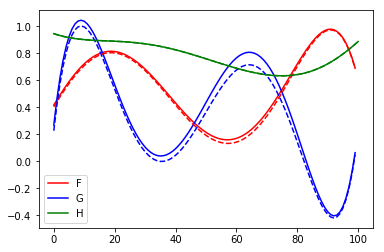

In [119]:
def check_U_der(get_funcs_UFGH, func_F_approx, func_G_approx, func_H_approx):

# Prepare to generate random, smooth data
    N = 100
    L = 10
    P = 6
    
    # Get data for a P - 1 order polynomial fit to P points
    def get_rand_curve(N, L, P): 
        x = np.linspace(0, L, N + 2)
        px = np.linspace(0, L, P)
        py = np.random.rand(P)
        y = np.poly1d(np.polyfit(px, py, P - 1))(x)
        return y

    # Helper variables to make sure guesses matches the end points
    X = get_rand_curve(N, L, P)
    Y = get_rand_curve(N, L, P)

# Calculate given varibles
    f = get_rand_curve(N, L, P)[1:-1]
    g = get_rand_curve(N, L, P)[1:-1]
    # Length must be greater than zero
    l = get_rand_curve(N, L, P)[1:] + 1
    (x0,  y0 ) = (X[ 0], Y[ 0])
    (xN1, yN1) = (X[-1], Y[-1])

    [func_U, func_F, func_G, func_H] = get_funcs_UFGH(f, g, l, x0, y0, xN1, yN1)

# Guess unknowns
    x = X[1:-1]
    y = Y[1:-1]
    T = get_rand_curve(N, L, P)[1:]
    

# Calculate forces
    F = func_F(x, y, T)
    G = func_G(x, y, T)
    H = func_H(x, y, T)

    # Scale is set much too large so we can see differences
    scale = 1
    Dx = scale*max(x[1:] - x[:-1])
    Dy = scale*max(y[1:] - y[:-1])
    DT = scale*max(T[1:] - T[:-1])

    F_approx = func_F_approx(x, y, T, func_U, Dx)
    G_approx = func_G_approx(x, y, T, func_U, Dy)
    H_approx = func_H_approx(x, y, T, func_U, DT)

# Plot
    plt.plot(F, 'r-', label = 'F')
    plt.plot(G, 'b-', label = 'G')
    plt.plot(H, 'g-', label = 'H')
    plt.plot(F_approx, 'r--')
    plt.plot(G_approx, 'b--')
    plt.plot(H_approx, 'g--')
    plt.legend()
    plt.show()
    
check_U_der(get_funcs_UFGH, func_F_approx, func_G_approx, func_H_approx)

<h3>Initial values</h3>

<p>The optimization algorithm requires initial guesses for the unknown variables $(x_i, y_i$) and $T_j$. A sensible guess for the positon variables $(x_i, y_i$) is a straight line connecting the end positions $(x_0, y_0)$ and $(x_{N+1}, y_{N+1})$. We guess that the tension variables $T_j$ are all equal to the same value, which is the average of the net tension on each mass.</p>

$$ T_j = \frac{1}{N} \sum_{i = 1}^N \sqrt{f_i^2 + g_i^2} $$

<p>There are problems with these guesses. Note, however, that many optimization algorithms start with random guesses and work fine.</p>

In [115]:
def get_x_init(x0, xN1, N):
    return np.linspace(x0, xN1, N + 2)[1:-1]

def get_y_init(y0, yN1, N):
    return np.linspace(y0, yN1, N + 2)[1:-1]

def get_T_init(f, g, N):
    return np.repeat(np.average(np.sqrt(f**2 + g**2)), N + 1)

<h3>Catenary</h3>

<p>To test our approach, we consider a problem that can be solved analytically. A catenary is a curve that idealizes a hanging chain. All mass values and string lengths are equal. The only external force is gravity. With this information, we rewrite the force equations.</p>

\begin{align*}
\frac{T_i}{\ell}\left(\frac{x_{i+1} - x_i}{\ell}\right) - \frac{T_{i-1}}{\ell}\left(\frac{x_i - x_{i-1}}{\ell}\right) &= 0 \\ 
\frac{T_i}{\ell}\left(\frac{y_{i+1} - y_i}{\ell}\right) - \frac{T_{i-1}}{\ell}\left(\frac{y_i - y_{i-1}}{\ell}\right) &= \frac{m g}{\ell}
\end{align*}
$$ \left(\frac{x_{j+1} - x_j}{\ell} \right)^2 + \left(\frac{y_{j+1} - y_j}{\ell} \right)^2 = 1 $$

<p>The catenary has mass $M = N m$ and length $L = (N + 1) \ell$. For large $N$, the discrete force equations become differential equations.</p>

$$ \frac{d}{ds} \left( T \frac{d x}{d s} \right) = 0, \quad
   \frac{d}{ds} \left( T \frac{d y}{d s} \right) = \frac{M g}{L}, \quad
   \left(\frac{d x}{d s}\right)^2 + \left(\frac{d y}{d s}\right)^2 = 1 $$
   
<p>The following functions are solutions. (See Appendix C.)</p>


$$ x(s) = R \sinh^{-1} \left( \frac{s}{R} \right), \quad
   y(s) = R \sqrt{1 + \left(\frac{s}{R} \right)^2}, \quad
   T(s) = \frac{M g R}{L} \sqrt{1 + \left(\frac{s}{R} \right)^2} $$

In [116]:
def get_funcs_xyT_catenary(M, L, R):

    def func_x_catenary(s):
        return R*np.arcsinh(s/R)
    
    def func_y_catenary(s):
        return R*np.sqrt(1 + (s/R)**2)
    
    def func_T_catenary(s):
        return M*gravity*R/L*np.sqrt(1 + (s/R)**2)

    return [func_x_catenary, func_y_catenary, func_T_catenary]

<h3>Test</h3>

<p>To test our approach, consider a catenary with mass $M$, length $L$, and radius of curvature $R$. We assume the catenary is made of $N$ masses. With this information, we can find given values.</p>

$$ (f_i, g_j) = \left(0, - \frac{M}{N} g\right), \quad
   \ell_j = \frac{L}{N + 1}, \quad
   (x_0, y_0) = \left(x\left(-\frac{L}{2}\right), y\left(-\frac{L}{2}\right)\right), \quad
   (x_{N1}, y_{N1}) = \left(x\left(\frac{L}{2}\right), y\left(\frac{L}{2}\right)\right) $$

         Current function value: -19800927289.131931
         Iterations: 5
         Function evaluations: 129
         Gradient evaluations: 117


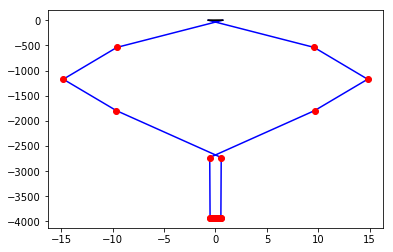

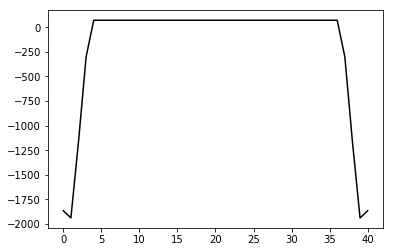

In [117]:
M = 10
L = 4
R = 0.25
N = 40

# Introduce catenary theory functions
[func_x_catenary, func_y_catenary, func_T_catenary] = get_funcs_xyT_catenary(M, L, R)

# Get data to plot
s = np.linspace(-L/2, L/2, 100*N)
x_catenary = func_x_catenary(s)
y_catenary = func_y_catenary(s)
T_catenary = func_T_catenary(s)

# Calculate givens
f = np.repeat(0, N)
g = np.repeat(-gravity*M/N, N)
l = np.repeat(L/(N + 1), N + 1)
[x0,  y0 ] = [func_x_catenary(-L/2), func_y_catenary(-L/2)]
[xN1, yN1] = [func_x_catenary( L/2), func_y_catenary( L/2)]

# Introduce functions and initial values
[func_U, func_F, func_G, func_H] = get_funcs_UFGH(f, g, l, x0, y0, xN1, yN1)

x_init = get_x_init(x0, xN1, N)
y_init = get_y_init(y0, yN1, N)
T_init = get_T_init(f, g, N)

# Optimize
[x, y, T] = minimumize_U_FGH_xyT(func_U, func_F, func_G, func_H, x_init, y_init, T_init, N)

# Plot

X = np.concatenate([[x0], x, [xN1]])
Y = np.concatenate([[y0], y, [yN1]])

plt.plot(x_catenary, y_catenary, 'k-')
plt.plot(X, Y, 'b-')
plt.plot(x, y, 'ro')
plt.plot(x_catenary, y_catenary, 'k-')
plt.show()

plt.plot(T, 'k-')
plt.show()

In [99]:
T_init

array([ 2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,
        2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,
        2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,
        2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,  2.45,
        2.45,  2.45,  2.45,  2.45,  2.45])

<h3>Chain in the wind</h3>

<h3>Chain with balloon</h3>

<h3>Appendix A</h3>

<p>Remember.</p>

$$ U = - \sum_{i=1}^N(f_i x_i + g_i y_i) 
  + \sum_{j=0}^N \frac{T_j}{2 \ell_j} \left[(x_{j+1} - x_j)^2 + (y_{j+1} - y_j)^2 - \ell_j^2 \right] $$

<p>Let $a$ range from $1$ to $N$.</p>

\begin{align*}
F_a = - \frac{\partial U}{\partial x_a} &=
  \sum_{i=1}^N f_i \delta_{i, a} 
 -\sum_{j=0}^N \frac{T_j}{\ell_j}(x_{j+1} - x_j)(\delta_{j+1, a} - \delta_{j, a}) \\
F_a = - \frac{\partial U}{\partial x_a} &=
  f_a - \frac{T_{a-1}}{\ell_{a-1}}(x_a - x_{a-1}) + \frac{T_a}{\ell_a}(x_{a+1} - x_a)
\end{align*}
   
<p>Replacing $a$ with $i$, we obtain the equation for $F_i$. The equation for $G_i$ is found in the same way.</p>


<h3>Appendix B</h3>

<p>Change notation.</p>

$$ x_i \rightarrow x(\ell i) = x(s) $$

<p>For large $N$, $\ell$ is small.</p>

$$ x_{i+1} \rightarrow x(s + \ell) \approx x(s) + \frac{d x}{d s} \ell + \frac{1}{2} \frac{d^2 x}{d s^2} \ell^2,
\quad
\frac{m}{\ell} = \frac{M (N + 1)}{L N} \approx \frac{M}{L} $$

<p>Consider, for example, the second force equation.</p>

$$ \frac{T_i}{\ell}\left(\frac{y_{i+1} - y_i}{\ell}\right) - \frac{T_{i-1}}{\ell}\left(\frac{y_i - y_{i-1}}{\ell}\right) = \frac{m g}{\ell} $$

<p>Assume $N$ is large.</p>

$$ \frac{T}{\ell}\left( \frac{d y}{d s} + \frac{1}{2} \frac{d^2 y}{d s^2} \ell \right)
 - \left( \frac{T}{\ell} - \frac{d T}{d s} + \frac{1}{2} \frac{d T}{d s} \ell \right)
 \left( \frac{d y}{d s} - \frac{1}{2} \frac{d^2 y}{d s^2} \ell \right) = \frac{M g}{L} $$

<p>Simplify.</p>
 
$$ T \frac{d^2 y}{d s^2} + \frac{d T}{d s} \frac{d y}{d s}
  + \frac{1}{2} \frac{d T}{d s} \frac{d y}{d s} \ell 
  - \frac{1}{4} \frac{d T}{d s} \frac{d^2 y}{d s^2} \ell^2
  = \frac{M g}{L} $$
  
<p>Drop higher order $\ell$ terms. The other force equations are found in a similar way.</p>



<h3>Appendix C</h3>

<p>The first equatin tells us that $T \frac{d x}{d s} = C_1$ where the constant can be interpreted as the $x$-component of tension in the chain. If we say $C_1 = \frac{M g R}{L}$, then $T = \frac{M g R}{L} \big/ \frac{d x}{d s}$.  Substitute $T$ into the second equation and eliminate $\frac{d x}{d s}$ or $\frac{d x}{d s}$ using the third equation.</p>

$$ \frac{d}{ds} \left(\sqrt{1 - \left(\frac{d x}{d s}\right)^2} \bigg/ \frac{d x}{d s} \right) = \frac{1}{R},
   \quad
   \frac{d}{ds} \left(\frac{d y}{d s} \bigg/ \sqrt{1 - \left(\frac{d y}{d s}\right)^2} \right) = \frac{1}{R} $$

<p>Integrate.</p>

$$ \sqrt{1 - \left(\frac{d x}{d s}\right)^2} \bigg/ \frac{d x}{d s} = \frac{s}{R} + C_2,
   \quad
   \frac{d y}{d s} \bigg/ \sqrt{1 - \left(\frac{d y}{d s}\right)^2} = \frac{s}{R} + C_3 $$

<p>If we assume that the chain is horizontal at $s = 0$, then $C_2 = C_3 = 0$.</p>

$$ \frac{d x}{d s} = \sqrt{\frac{R^2}{R^2 + s^2}}, \quad
   \frac{d y}{d s} = \sqrt{\frac{s^2}{R^2 + s^2}} $$

<p>Integrate.</p>

$$ x(s) = R \sinh^{-1} \left( \frac{s}{R} \right) + C_4, \quad
   y(s) = R \sqrt{1 + \left(\frac{s}{R} \right)^2} + C_5 $$
   
<p>Constants $C_4$ and $C_5$ result in a translation. We set them to zero.</p>

$$ T(s) = \frac{M g R}{L} \sqrt{1 + \left(\frac{s}{R} \right)^2} $$